# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

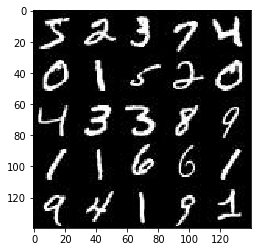

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

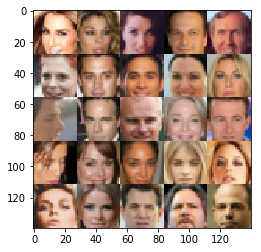

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use GPU:0

config = tf.ConfigProto()
config.gpu_options.allow_growth=True # Increase accroding to the usage
#config.gpu_options.per_process_gpu_memory_fraction = 0.4 # Using memory according to the percentage : 40% 

with tf.Session(config=config) as sess :
    # Check TensorFlow Version
    assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
    print('TensorFlow Version: {}'.format(tf.__version__))

    # Check for a GPU
    if not tf.test.gpu_device_name():
        warnings.warn('No GPU found. Please use a GPU to train your neural network.')
    else:
        print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.5
        # Input layer is 28 * 28 * 3
        
        # x1 : 14 * 14 * 64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # x2 : 7 * 7 * 28
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # x3 : 4 * 4 * 256
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.2
        
        # Reshpae to 7 * 7 * 256
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x1, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14 * 14 * 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28 * 28 * 3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')   
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function  
    d_model_real, d_logits_real = discriminator(input_real)
    
    g_model = generator(input_z, out_channel_dim)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))   
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
       
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if step % show_steps == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, Step {} ...".format(epoch_i+1, epochs, step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % (show_steps * 10) == 0:                
                    show_generator_output(sess, 6, input_z, data_shape[3], data_image_mode)
                    
                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5, Step 0 ... Discriminator Loss: 23.6086... Generator Loss: 0.0000


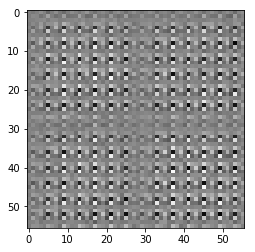

Epoch 1/5, Step 10 ... Discriminator Loss: 0.1769... Generator Loss: 19.7819
Epoch 1/5, Step 20 ... Discriminator Loss: 0.1420... Generator Loss: 4.4961
Epoch 1/5, Step 30 ... Discriminator Loss: 0.0899... Generator Loss: 3.3821
Epoch 1/5, Step 40 ... Discriminator Loss: 0.3097... Generator Loss: 2.6070
Epoch 1/5, Step 50 ... Discriminator Loss: 0.6835... Generator Loss: 1.3623
Epoch 1/5, Step 60 ... Discriminator Loss: 0.2385... Generator Loss: 4.2181
Epoch 1/5, Step 70 ... Discriminator Loss: 1.5666... Generator Loss: 1.9098
Epoch 1/5, Step 80 ... Discriminator Loss: 2.6243... Generator Loss: 0.4807
Epoch 1/5, Step 90 ... Discriminator Loss: 0.1140... Generator Loss: 2.9158
Epoch 1/5, Step 100 ... Discriminator Loss: 0.0724... Generator Loss: 3.8553


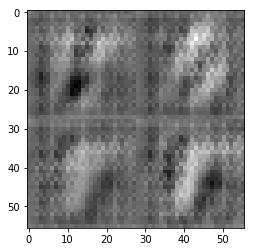

Epoch 1/5, Step 110 ... Discriminator Loss: 0.0986... Generator Loss: 2.9290
Epoch 1/5, Step 120 ... Discriminator Loss: 0.1420... Generator Loss: 2.9301
Epoch 1/5, Step 130 ... Discriminator Loss: 0.0002... Generator Loss: 11.8180
Epoch 1/5, Step 140 ... Discriminator Loss: 0.0041... Generator Loss: 7.6787
Epoch 1/5, Step 150 ... Discriminator Loss: 0.0113... Generator Loss: 9.5426
Epoch 1/5, Step 160 ... Discriminator Loss: 0.0301... Generator Loss: 4.8846
Epoch 1/5, Step 170 ... Discriminator Loss: 1.3782... Generator Loss: 0.5065
Epoch 1/5, Step 180 ... Discriminator Loss: 0.0468... Generator Loss: 9.0804
Epoch 1/5, Step 190 ... Discriminator Loss: 1.2300... Generator Loss: 4.3329
Epoch 1/5, Step 200 ... Discriminator Loss: 0.1562... Generator Loss: 2.7881


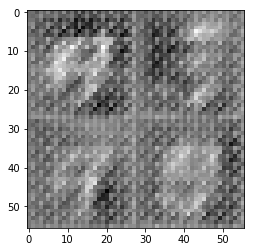

Epoch 1/5, Step 210 ... Discriminator Loss: 0.8541... Generator Loss: 1.1224
Epoch 1/5, Step 220 ... Discriminator Loss: 0.4753... Generator Loss: 4.1772
Epoch 1/5, Step 230 ... Discriminator Loss: 0.0052... Generator Loss: 8.0310
Epoch 1/5, Step 240 ... Discriminator Loss: 0.6673... Generator Loss: 1.0174
Epoch 1/5, Step 250 ... Discriminator Loss: 0.0214... Generator Loss: 8.1971
Epoch 1/5, Step 260 ... Discriminator Loss: 0.5650... Generator Loss: 1.3884
Epoch 1/5, Step 270 ... Discriminator Loss: 0.6824... Generator Loss: 4.2738
Epoch 1/5, Step 280 ... Discriminator Loss: 0.6768... Generator Loss: 0.7868
Epoch 1/5, Step 290 ... Discriminator Loss: 0.0500... Generator Loss: 9.9227
Epoch 1/5, Step 300 ... Discriminator Loss: 0.1428... Generator Loss: 6.4853


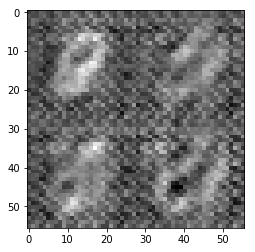

Epoch 1/5, Step 310 ... Discriminator Loss: 0.1393... Generator Loss: 9.2818
Epoch 1/5, Step 320 ... Discriminator Loss: 0.0209... Generator Loss: 4.8817
Epoch 1/5, Step 330 ... Discriminator Loss: 0.0151... Generator Loss: 10.5395
Epoch 1/5, Step 340 ... Discriminator Loss: 0.0078... Generator Loss: 8.0046
Epoch 1/5, Step 350 ... Discriminator Loss: 0.0060... Generator Loss: 8.1259
Epoch 1/5, Step 360 ... Discriminator Loss: 0.2786... Generator Loss: 1.6720
Epoch 1/5, Step 370 ... Discriminator Loss: 2.2811... Generator Loss: 0.1741
Epoch 1/5, Step 380 ... Discriminator Loss: 0.0625... Generator Loss: 4.6338
Epoch 1/5, Step 390 ... Discriminator Loss: 0.4123... Generator Loss: 1.2939
Epoch 1/5, Step 400 ... Discriminator Loss: 0.0547... Generator Loss: 4.5388


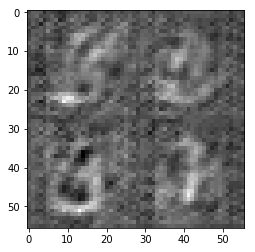

Epoch 1/5, Step 410 ... Discriminator Loss: 0.0933... Generator Loss: 2.7647
Epoch 1/5, Step 420 ... Discriminator Loss: 0.0418... Generator Loss: 4.2232
Epoch 1/5, Step 430 ... Discriminator Loss: 0.0871... Generator Loss: 8.8079
Epoch 1/5, Step 440 ... Discriminator Loss: 0.0041... Generator Loss: 7.8880
Epoch 1/5, Step 450 ... Discriminator Loss: 0.0962... Generator Loss: 3.1103
Epoch 1/5, Step 460 ... Discriminator Loss: 1.9332... Generator Loss: 0.2314
Epoch 2/5, Step 470 ... Discriminator Loss: 0.0072... Generator Loss: 8.2802
Epoch 2/5, Step 480 ... Discriminator Loss: 0.0145... Generator Loss: 5.5976
Epoch 2/5, Step 490 ... Discriminator Loss: 0.0299... Generator Loss: 6.5409
Epoch 2/5, Step 500 ... Discriminator Loss: 0.1272... Generator Loss: 2.6758


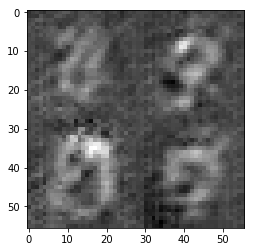

Epoch 2/5, Step 510 ... Discriminator Loss: 0.2667... Generator Loss: 8.3323
Epoch 2/5, Step 520 ... Discriminator Loss: 0.0124... Generator Loss: 8.3821
Epoch 2/5, Step 530 ... Discriminator Loss: 0.0172... Generator Loss: 6.7413
Epoch 2/5, Step 540 ... Discriminator Loss: 0.3378... Generator Loss: 5.4510
Epoch 2/5, Step 550 ... Discriminator Loss: 0.6037... Generator Loss: 2.5468
Epoch 2/5, Step 560 ... Discriminator Loss: 1.6911... Generator Loss: 0.3465
Epoch 2/5, Step 570 ... Discriminator Loss: 0.2064... Generator Loss: 3.2256
Epoch 2/5, Step 580 ... Discriminator Loss: 1.1911... Generator Loss: 0.7520
Epoch 2/5, Step 590 ... Discriminator Loss: 1.7599... Generator Loss: 3.5813
Epoch 2/5, Step 600 ... Discriminator Loss: 0.4637... Generator Loss: 5.3593


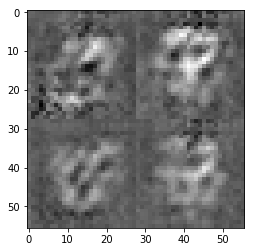

Epoch 2/5, Step 610 ... Discriminator Loss: 1.1398... Generator Loss: 0.5479
Epoch 2/5, Step 620 ... Discriminator Loss: 0.7566... Generator Loss: 1.2620
Epoch 2/5, Step 630 ... Discriminator Loss: 0.2634... Generator Loss: 2.8930
Epoch 2/5, Step 640 ... Discriminator Loss: 1.6624... Generator Loss: 0.3300
Epoch 2/5, Step 650 ... Discriminator Loss: 1.8941... Generator Loss: 6.7770
Epoch 2/5, Step 660 ... Discriminator Loss: 0.5357... Generator Loss: 2.5319
Epoch 2/5, Step 670 ... Discriminator Loss: 0.7227... Generator Loss: 3.0981
Epoch 2/5, Step 680 ... Discriminator Loss: 1.0904... Generator Loss: 0.6602
Epoch 2/5, Step 690 ... Discriminator Loss: 0.8219... Generator Loss: 1.0096
Epoch 2/5, Step 700 ... Discriminator Loss: 1.0647... Generator Loss: 0.7108


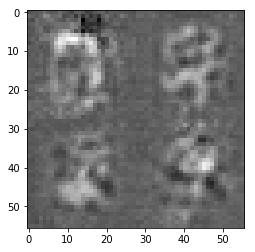

Epoch 2/5, Step 710 ... Discriminator Loss: 0.6479... Generator Loss: 1.4968
Epoch 2/5, Step 720 ... Discriminator Loss: 0.6297... Generator Loss: 2.5335
Epoch 2/5, Step 730 ... Discriminator Loss: 0.3200... Generator Loss: 2.1038
Epoch 2/5, Step 740 ... Discriminator Loss: 0.7791... Generator Loss: 5.5212
Epoch 2/5, Step 750 ... Discriminator Loss: 0.4073... Generator Loss: 2.3900
Epoch 2/5, Step 760 ... Discriminator Loss: 0.4665... Generator Loss: 2.4065
Epoch 2/5, Step 770 ... Discriminator Loss: 1.5124... Generator Loss: 0.3372
Epoch 2/5, Step 780 ... Discriminator Loss: 0.6960... Generator Loss: 0.9389
Epoch 2/5, Step 790 ... Discriminator Loss: 1.0546... Generator Loss: 0.6791
Epoch 2/5, Step 800 ... Discriminator Loss: 0.8484... Generator Loss: 0.8468


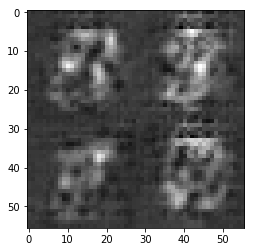

Epoch 2/5, Step 810 ... Discriminator Loss: 0.1108... Generator Loss: 3.6948
Epoch 2/5, Step 820 ... Discriminator Loss: 2.2237... Generator Loss: 5.0337
Epoch 2/5, Step 830 ... Discriminator Loss: 1.5910... Generator Loss: 0.2961
Epoch 2/5, Step 840 ... Discriminator Loss: 1.0257... Generator Loss: 0.6374
Epoch 2/5, Step 850 ... Discriminator Loss: 0.3328... Generator Loss: 1.6486
Epoch 2/5, Step 860 ... Discriminator Loss: 0.2181... Generator Loss: 2.4782
Epoch 2/5, Step 870 ... Discriminator Loss: 0.7063... Generator Loss: 2.9701
Epoch 2/5, Step 880 ... Discriminator Loss: 0.2009... Generator Loss: 2.3956
Epoch 2/5, Step 890 ... Discriminator Loss: 0.2376... Generator Loss: 2.8979
Epoch 2/5, Step 900 ... Discriminator Loss: 0.3285... Generator Loss: 4.1689


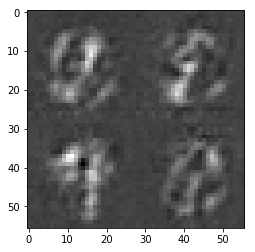

Epoch 2/5, Step 910 ... Discriminator Loss: 0.6463... Generator Loss: 0.9262
Epoch 2/5, Step 920 ... Discriminator Loss: 0.2204... Generator Loss: 2.7977
Epoch 2/5, Step 930 ... Discriminator Loss: 1.0863... Generator Loss: 0.5453
Epoch 3/5, Step 940 ... Discriminator Loss: 0.9364... Generator Loss: 0.7166
Epoch 3/5, Step 950 ... Discriminator Loss: 0.4440... Generator Loss: 1.6787
Epoch 3/5, Step 960 ... Discriminator Loss: 0.3437... Generator Loss: 1.8734
Epoch 3/5, Step 970 ... Discriminator Loss: 0.2567... Generator Loss: 1.9255
Epoch 3/5, Step 980 ... Discriminator Loss: 0.3953... Generator Loss: 1.4838
Epoch 3/5, Step 990 ... Discriminator Loss: 0.4189... Generator Loss: 2.6121
Epoch 3/5, Step 1000 ... Discriminator Loss: 0.1604... Generator Loss: 2.5593


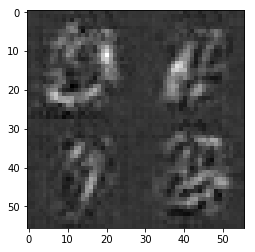

Epoch 3/5, Step 1010 ... Discriminator Loss: 0.1050... Generator Loss: 3.3734
Epoch 3/5, Step 1020 ... Discriminator Loss: 0.4019... Generator Loss: 1.2703
Epoch 3/5, Step 1030 ... Discriminator Loss: 0.1241... Generator Loss: 2.6174
Epoch 3/5, Step 1040 ... Discriminator Loss: 0.1864... Generator Loss: 2.1648
Epoch 3/5, Step 1050 ... Discriminator Loss: 0.0892... Generator Loss: 3.0386
Epoch 3/5, Step 1060 ... Discriminator Loss: 0.0887... Generator Loss: 3.0677
Epoch 3/5, Step 1070 ... Discriminator Loss: 0.1522... Generator Loss: 2.4185
Epoch 3/5, Step 1080 ... Discriminator Loss: 0.0807... Generator Loss: 3.1047
Epoch 3/5, Step 1090 ... Discriminator Loss: 0.2135... Generator Loss: 2.5382
Epoch 3/5, Step 1100 ... Discriminator Loss: 1.1513... Generator Loss: 1.2852


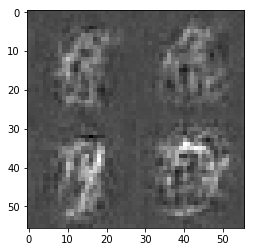

Epoch 3/5, Step 1110 ... Discriminator Loss: 0.8619... Generator Loss: 1.7069
Epoch 3/5, Step 1120 ... Discriminator Loss: 0.4895... Generator Loss: 1.2362
Epoch 3/5, Step 1130 ... Discriminator Loss: 0.6873... Generator Loss: 2.1303
Epoch 3/5, Step 1140 ... Discriminator Loss: 0.9164... Generator Loss: 1.3842
Epoch 3/5, Step 1150 ... Discriminator Loss: 0.7037... Generator Loss: 1.0205
Epoch 3/5, Step 1160 ... Discriminator Loss: 0.4808... Generator Loss: 1.8899
Epoch 3/5, Step 1170 ... Discriminator Loss: 0.6546... Generator Loss: 0.9955
Epoch 3/5, Step 1180 ... Discriminator Loss: 0.4365... Generator Loss: 1.4701
Epoch 3/5, Step 1190 ... Discriminator Loss: 0.0794... Generator Loss: 3.3490
Epoch 3/5, Step 1200 ... Discriminator Loss: 0.2725... Generator Loss: 1.7139


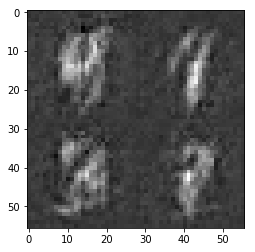

Epoch 3/5, Step 1210 ... Discriminator Loss: 0.2511... Generator Loss: 1.7087
Epoch 3/5, Step 1220 ... Discriminator Loss: 0.1584... Generator Loss: 2.1839
Epoch 3/5, Step 1230 ... Discriminator Loss: 0.3959... Generator Loss: 1.2362
Epoch 3/5, Step 1240 ... Discriminator Loss: 0.0440... Generator Loss: 3.8784
Epoch 3/5, Step 1250 ... Discriminator Loss: 0.0268... Generator Loss: 4.9360
Epoch 3/5, Step 1260 ... Discriminator Loss: 0.0861... Generator Loss: 2.8336
Epoch 3/5, Step 1270 ... Discriminator Loss: 0.1609... Generator Loss: 2.1128
Epoch 3/5, Step 1280 ... Discriminator Loss: 0.0472... Generator Loss: 3.8491
Epoch 3/5, Step 1290 ... Discriminator Loss: 0.2300... Generator Loss: 1.7394
Epoch 3/5, Step 1300 ... Discriminator Loss: 0.0383... Generator Loss: 4.1223


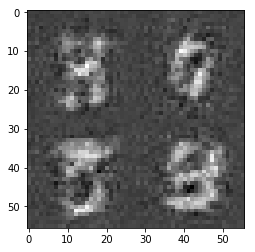

Epoch 3/5, Step 1310 ... Discriminator Loss: 0.1041... Generator Loss: 2.5762
Epoch 3/5, Step 1320 ... Discriminator Loss: 0.0577... Generator Loss: 3.3605
Epoch 3/5, Step 1330 ... Discriminator Loss: 0.0385... Generator Loss: 3.8570
Epoch 3/5, Step 1340 ... Discriminator Loss: 0.0481... Generator Loss: 3.4035
Epoch 3/5, Step 1350 ... Discriminator Loss: 0.0254... Generator Loss: 4.2065
Epoch 3/5, Step 1360 ... Discriminator Loss: 0.0419... Generator Loss: 3.7105
Epoch 3/5, Step 1370 ... Discriminator Loss: 0.0170... Generator Loss: 5.0704
Epoch 3/5, Step 1380 ... Discriminator Loss: 0.0247... Generator Loss: 4.2386
Epoch 3/5, Step 1390 ... Discriminator Loss: 0.0080... Generator Loss: 5.7043
Epoch 3/5, Step 1400 ... Discriminator Loss: 0.0147... Generator Loss: 4.8667


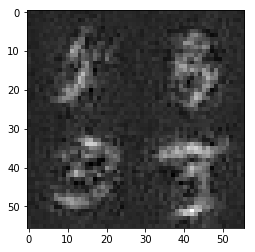

Epoch 4/5, Step 1410 ... Discriminator Loss: 0.0133... Generator Loss: 5.0798
Epoch 4/5, Step 1420 ... Discriminator Loss: 0.1324... Generator Loss: 2.3485
Epoch 4/5, Step 1430 ... Discriminator Loss: 0.0681... Generator Loss: 3.0325
Epoch 4/5, Step 1440 ... Discriminator Loss: 0.0432... Generator Loss: 3.5215
Epoch 4/5, Step 1450 ... Discriminator Loss: 0.0378... Generator Loss: 3.6181
Epoch 4/5, Step 1460 ... Discriminator Loss: 2.1469... Generator Loss: 0.2569
Epoch 4/5, Step 1470 ... Discriminator Loss: 1.5123... Generator Loss: 1.2223
Epoch 4/5, Step 1480 ... Discriminator Loss: 1.3158... Generator Loss: 0.7411
Epoch 4/5, Step 1490 ... Discriminator Loss: 0.8992... Generator Loss: 1.1118
Epoch 4/5, Step 1500 ... Discriminator Loss: 0.8937... Generator Loss: 1.0966


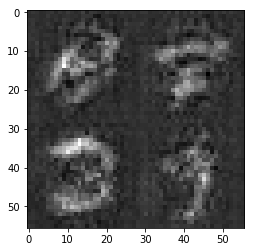

Epoch 4/5, Step 1510 ... Discriminator Loss: 1.1193... Generator Loss: 1.2409
Epoch 4/5, Step 1520 ... Discriminator Loss: 1.0640... Generator Loss: 0.7254
Epoch 4/5, Step 1530 ... Discriminator Loss: 1.5336... Generator Loss: 0.3803
Epoch 4/5, Step 1540 ... Discriminator Loss: 1.2943... Generator Loss: 2.7260
Epoch 4/5, Step 1550 ... Discriminator Loss: 0.7351... Generator Loss: 0.9708
Epoch 4/5, Step 1560 ... Discriminator Loss: 1.0331... Generator Loss: 0.8570
Epoch 4/5, Step 1570 ... Discriminator Loss: 0.8984... Generator Loss: 0.9825
Epoch 4/5, Step 1580 ... Discriminator Loss: 0.9263... Generator Loss: 1.0444
Epoch 4/5, Step 1590 ... Discriminator Loss: 0.6903... Generator Loss: 1.0302
Epoch 4/5, Step 1600 ... Discriminator Loss: 0.4754... Generator Loss: 1.5946


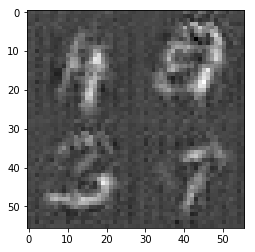

Epoch 4/5, Step 1610 ... Discriminator Loss: 0.9503... Generator Loss: 0.7136
Epoch 4/5, Step 1620 ... Discriminator Loss: 0.7601... Generator Loss: 1.4216
Epoch 4/5, Step 1630 ... Discriminator Loss: 1.0103... Generator Loss: 0.6353
Epoch 4/5, Step 1640 ... Discriminator Loss: 1.4728... Generator Loss: 3.6343
Epoch 4/5, Step 1650 ... Discriminator Loss: 0.5855... Generator Loss: 2.1249
Epoch 4/5, Step 1660 ... Discriminator Loss: 1.2381... Generator Loss: 0.5906
Epoch 4/5, Step 1670 ... Discriminator Loss: 0.6127... Generator Loss: 3.0611
Epoch 4/5, Step 1680 ... Discriminator Loss: 1.0407... Generator Loss: 0.6206
Epoch 4/5, Step 1690 ... Discriminator Loss: 1.1562... Generator Loss: 3.7884
Epoch 4/5, Step 1700 ... Discriminator Loss: 0.5574... Generator Loss: 2.2901


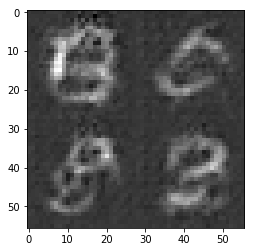

Epoch 4/5, Step 1710 ... Discriminator Loss: 0.9366... Generator Loss: 3.6055
Epoch 4/5, Step 1720 ... Discriminator Loss: 0.4461... Generator Loss: 2.2356
Epoch 4/5, Step 1730 ... Discriminator Loss: 0.4296... Generator Loss: 1.4829
Epoch 4/5, Step 1740 ... Discriminator Loss: 0.3247... Generator Loss: 1.7816
Epoch 4/5, Step 1750 ... Discriminator Loss: 0.3099... Generator Loss: 3.4540
Epoch 4/5, Step 1760 ... Discriminator Loss: 0.2976... Generator Loss: 1.8700
Epoch 4/5, Step 1770 ... Discriminator Loss: 0.1785... Generator Loss: 2.5541
Epoch 4/5, Step 1780 ... Discriminator Loss: 0.1743... Generator Loss: 2.4121
Epoch 4/5, Step 1790 ... Discriminator Loss: 1.8798... Generator Loss: 4.3842
Epoch 4/5, Step 1800 ... Discriminator Loss: 0.5305... Generator Loss: 2.1601


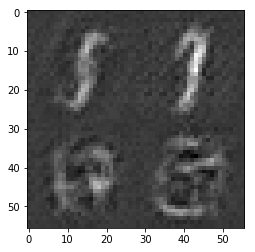

Epoch 4/5, Step 1810 ... Discriminator Loss: 0.2536... Generator Loss: 1.9999
Epoch 4/5, Step 1820 ... Discriminator Loss: 0.1424... Generator Loss: 2.5599
Epoch 4/5, Step 1830 ... Discriminator Loss: 0.1161... Generator Loss: 2.7098
Epoch 4/5, Step 1840 ... Discriminator Loss: 0.1278... Generator Loss: 2.6409
Epoch 4/5, Step 1850 ... Discriminator Loss: 0.1470... Generator Loss: 2.2869
Epoch 4/5, Step 1860 ... Discriminator Loss: 0.1818... Generator Loss: 2.1341
Epoch 4/5, Step 1870 ... Discriminator Loss: 0.0777... Generator Loss: 3.3439
Epoch 5/5, Step 1880 ... Discriminator Loss: 0.1012... Generator Loss: 2.7692
Epoch 5/5, Step 1890 ... Discriminator Loss: 1.3031... Generator Loss: 1.1479
Epoch 5/5, Step 1900 ... Discriminator Loss: 0.8269... Generator Loss: 1.5252


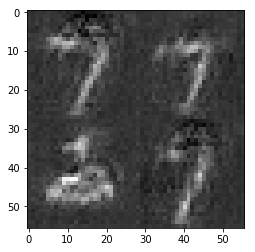

Epoch 5/5, Step 1910 ... Discriminator Loss: 0.7492... Generator Loss: 1.9803
Epoch 5/5, Step 1920 ... Discriminator Loss: 0.5872... Generator Loss: 1.3843
Epoch 5/5, Step 1930 ... Discriminator Loss: 0.8267... Generator Loss: 1.4924
Epoch 5/5, Step 1940 ... Discriminator Loss: 1.1175... Generator Loss: 0.5587
Epoch 5/5, Step 1950 ... Discriminator Loss: 0.8186... Generator Loss: 1.1559
Epoch 5/5, Step 1960 ... Discriminator Loss: 1.5436... Generator Loss: 0.3368
Epoch 5/5, Step 1970 ... Discriminator Loss: 0.3662... Generator Loss: 2.0909
Epoch 5/5, Step 1980 ... Discriminator Loss: 0.2912... Generator Loss: 1.8143
Epoch 5/5, Step 1990 ... Discriminator Loss: 0.2850... Generator Loss: 1.6555
Epoch 5/5, Step 2000 ... Discriminator Loss: 0.1504... Generator Loss: 2.3884


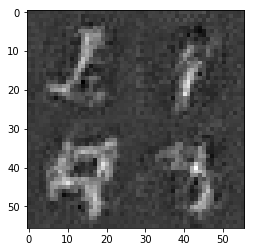

Epoch 5/5, Step 2010 ... Discriminator Loss: 0.1220... Generator Loss: 2.5972
Epoch 5/5, Step 2020 ... Discriminator Loss: 0.0742... Generator Loss: 3.0566
Epoch 5/5, Step 2030 ... Discriminator Loss: 0.2901... Generator Loss: 1.5653
Epoch 5/5, Step 2040 ... Discriminator Loss: 0.0241... Generator Loss: 4.6704
Epoch 5/5, Step 2050 ... Discriminator Loss: 0.0245... Generator Loss: 4.6097
Epoch 5/5, Step 2060 ... Discriminator Loss: 0.0153... Generator Loss: 5.0273
Epoch 5/5, Step 2070 ... Discriminator Loss: 0.0742... Generator Loss: 2.8699
Epoch 5/5, Step 2080 ... Discriminator Loss: 0.0323... Generator Loss: 3.9596
Epoch 5/5, Step 2090 ... Discriminator Loss: 0.0468... Generator Loss: 3.5316
Epoch 5/5, Step 2100 ... Discriminator Loss: 0.0418... Generator Loss: 3.5734


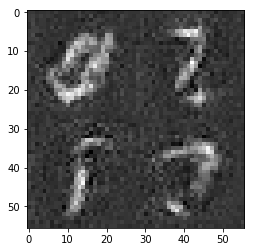

Epoch 5/5, Step 2110 ... Discriminator Loss: 0.0315... Generator Loss: 3.9132
Epoch 5/5, Step 2120 ... Discriminator Loss: 0.0751... Generator Loss: 2.8457
Epoch 5/5, Step 2130 ... Discriminator Loss: 0.0100... Generator Loss: 6.1730
Epoch 5/5, Step 2140 ... Discriminator Loss: 0.0137... Generator Loss: 5.2585
Epoch 5/5, Step 2150 ... Discriminator Loss: 0.0199... Generator Loss: 4.5768
Epoch 5/5, Step 2160 ... Discriminator Loss: 0.0386... Generator Loss: 3.5314
Epoch 5/5, Step 2170 ... Discriminator Loss: 0.0423... Generator Loss: 3.6526
Epoch 5/5, Step 2180 ... Discriminator Loss: 0.0320... Generator Loss: 3.8296
Epoch 5/5, Step 2190 ... Discriminator Loss: 0.0075... Generator Loss: 5.5480
Epoch 5/5, Step 2200 ... Discriminator Loss: 0.1556... Generator Loss: 3.3175


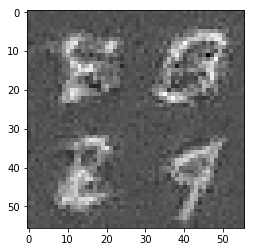

Epoch 5/5, Step 2210 ... Discriminator Loss: 1.0587... Generator Loss: 1.3396
Epoch 5/5, Step 2220 ... Discriminator Loss: 0.9451... Generator Loss: 1.1361
Epoch 5/5, Step 2230 ... Discriminator Loss: 1.0631... Generator Loss: 0.9490
Epoch 5/5, Step 2240 ... Discriminator Loss: 0.9707... Generator Loss: 1.2313
Epoch 5/5, Step 2250 ... Discriminator Loss: 1.7185... Generator Loss: 2.9389
Epoch 5/5, Step 2260 ... Discriminator Loss: 0.8940... Generator Loss: 0.9068
Epoch 5/5, Step 2270 ... Discriminator Loss: 0.7750... Generator Loss: 1.2551
Epoch 5/5, Step 2280 ... Discriminator Loss: 0.9774... Generator Loss: 0.7835
Epoch 5/5, Step 2290 ... Discriminator Loss: 0.7764... Generator Loss: 1.1374
Epoch 5/5, Step 2300 ... Discriminator Loss: 0.8140... Generator Loss: 1.0673


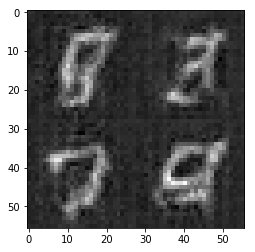

Epoch 5/5, Step 2310 ... Discriminator Loss: 0.9331... Generator Loss: 0.8134
Epoch 5/5, Step 2320 ... Discriminator Loss: 0.8731... Generator Loss: 2.8081
Epoch 5/5, Step 2330 ... Discriminator Loss: 0.8837... Generator Loss: 2.0748
Finished!


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
show_steps = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print("Finished!")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/20, Step 0 ... Discriminator Loss: 20.5237... Generator Loss: 0.0000


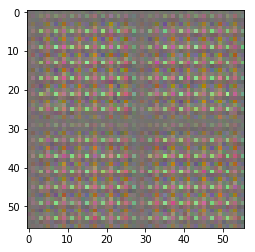

Epoch 1/20, Step 10 ... Discriminator Loss: 0.1401... Generator Loss: 17.1000
Epoch 1/20, Step 20 ... Discriminator Loss: 0.0588... Generator Loss: 6.8315
Epoch 1/20, Step 30 ... Discriminator Loss: 0.1159... Generator Loss: 5.8814
Epoch 1/20, Step 40 ... Discriminator Loss: 0.0323... Generator Loss: 4.9835
Epoch 1/20, Step 50 ... Discriminator Loss: 0.8599... Generator Loss: 1.6813
Epoch 1/20, Step 60 ... Discriminator Loss: 0.3895... Generator Loss: 2.9062
Epoch 1/20, Step 70 ... Discriminator Loss: 0.0371... Generator Loss: 5.6826
Epoch 1/20, Step 80 ... Discriminator Loss: 0.0255... Generator Loss: 5.5901
Epoch 1/20, Step 90 ... Discriminator Loss: 0.0292... Generator Loss: 4.6205
Epoch 1/20, Step 100 ... Discriminator Loss: 0.0181... Generator Loss: 4.8063


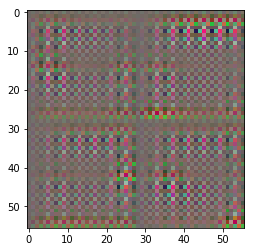

Epoch 1/20, Step 110 ... Discriminator Loss: 0.0219... Generator Loss: 4.6153


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.8
show_steps = 10

"""
DON'T MO
DIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.